In [16]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import pandas as pd
import matplotlib.dates as mdates
import os
import yaml
import numpy as np
import copy
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

home       = os.path.expanduser("~")
yaml_path  = os.path.join(home, 'dirpaths.yaml')
data_dir   = yaml.safe_load(open(yaml_path))['DATA_PATH']

fname      = 'era5_warm.vars.nc'
fpath      = os.path.join(data_dir, 'jules', 'output', 'era5_larsen_b_grid_point', fname)
output     = nc.Dataset(fpath, 'r')
start_time = pd.Timestamp('2013-01-01 00:00')

In [17]:
# constant hot forcing, firn temp initialised to -10oC 
# no percolation: l_snow_infilt=.false.
# no spectral albedo l_spec_albedo=.false.

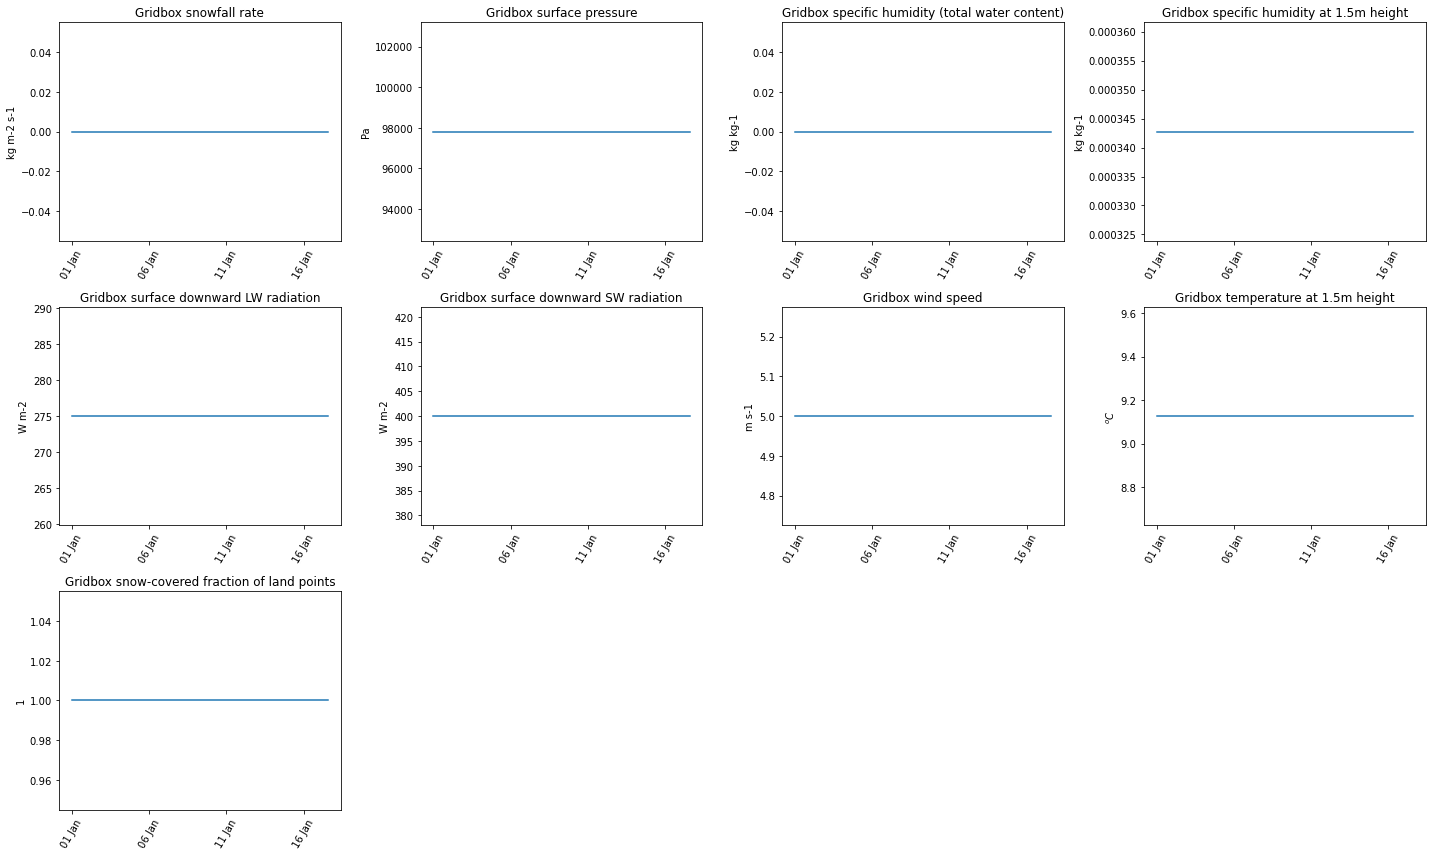

In [18]:
# plot all vars with dimensions (time, y, x)
gb_vars = [v for v in output.variables if output.variables[v].dimensions == ('time', 'y', 'x')]
#gb_vars = ['snowfall','pstar','qw1','lw_down','sw_down','wind','t1p5m_gb']

fig, axes = plt.subplots(-(-len(gb_vars) // 4), 4, figsize=(20, 4 * ((len(gb_vars) + 3) // 4)))
axes = axes.flat

for ax, v in zip(axes, gb_vars):
    data = output[v][1:400, 0, 0]
    

    units = getattr(output[v], 'units', '')    
    time = pd.date_range(start=start_time, periods=len(data), freq='H')

    if v == 't1p5m_gb':
        data -= 273.15
        units = '$^oC$'
        
    ax.plot(time, data)
    ax.set_title(getattr(output[v], 'long_name', v))
    ax.set_ylabel(units)
    
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

    
    ax.tick_params(axis='x', rotation=60)

for ax in axes[len(gb_vars):]:
    ax.remove()

plt.tight_layout()
plt.show()

In [19]:
nsnow = output['nsnow'][:, 8, 0, 0]
print(nsnow)

[49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49.
 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49.
 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49.
 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49.
 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49.
 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49.
 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49.
 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49.
 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49.
 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49.
 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49.
 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49.
 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49.
 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49

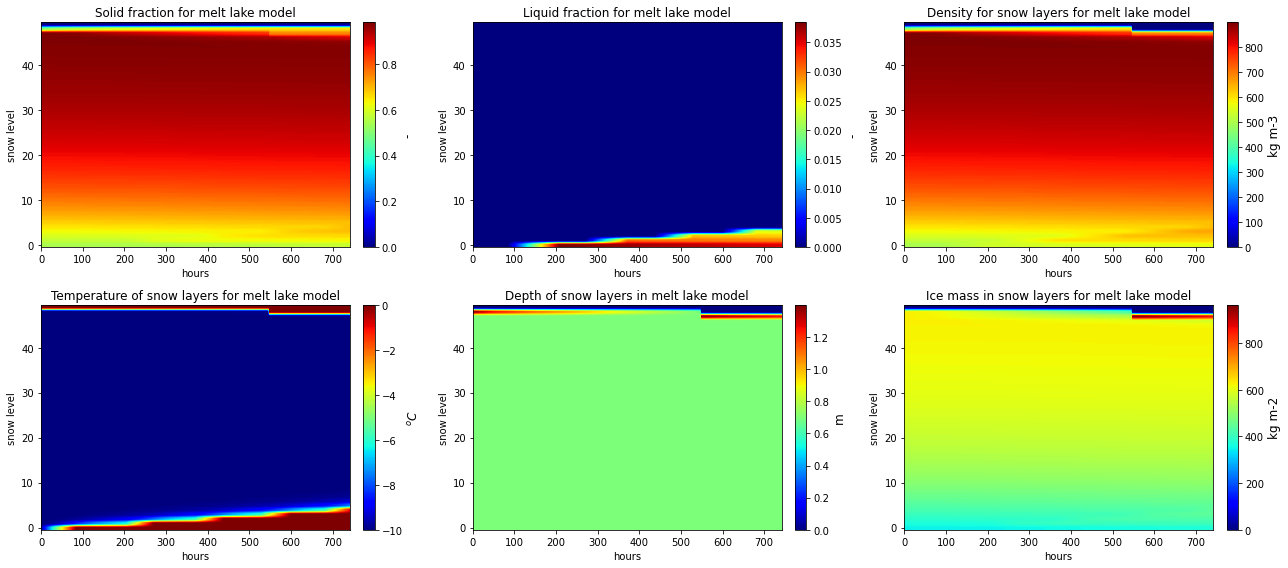

In [20]:
# plot all vars with dimensions (time, snow, tile, y, x) 
snow_vars = [v for v in output.variables if output.variables[v].dimensions == ('time', 'snow_ml', 'tile', 'y', 'x')]
#snow_vars = ['sfrac_ml', 'lfrac_ml', 'rho_snow_ml', 'tsnow_ml', 'snow_ice_ml', 'snow_liq_ml']
fig, axes = plt.subplots(2, 3, figsize=(18, 8))  
axes = axes.flat


for ax, v in zip(axes, snow_vars):
    
    data_2d = output[v][:,:, -1, 0, 0]
    units = getattr(output[v], 'units', '')  
    time = pd.date_range(start=start_time, periods=len(data_2d), freq='H')
    
    if v == 'tsnow_ml':
        data_2d -= 273.15
        units = '$^oC$'
        
    im = ax.imshow(data_2d.T,aspect='auto', origin='lower', cmap='jet')
    ax.set_title(getattr(output[v], 'long_name', v))
    ax.set_ylabel('snow level')
    ax.set_xlabel('hours')
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label(units, fontsize=12)
    #ax.set_ylim(0, 10)
    
for ax in axes[len(snow_vars):]:
    ax.remove()

plt.tight_layout()
plt.show()

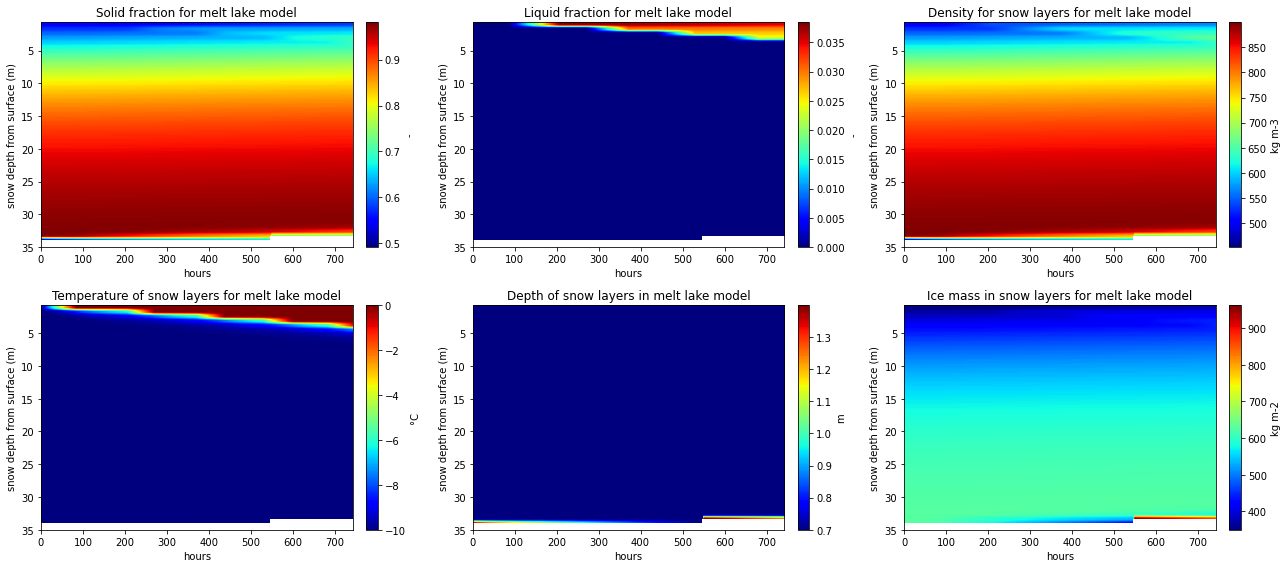

In [31]:
depth = np.arange(35, 0, -0.7)  

snow_vars = [v for v in output.variables
             if output.variables[v].dimensions == ('time', 'snow_ml', 'tile', 'y', 'x')]

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flat

nsnow = output['nsnow'][:, 8, 0, 0].astype(int)

# safe colormap copy
cmap = copy.copy(plt.cm.get_cmap('jet'))
cmap.set_bad('white')

for ax, v in zip(axes, snow_vars):

    data = np.array(output[v][:,:, -1, 0, 0])
    units = getattr(output[v], 'units', '')
    if v == 'tsnow_ml':
        data -= 273.15
        units = '°C'

    # mask inactive levels
    for t, n_active in enumerate(nsnow):
        if n_active < data.shape[1]:
            data[t, n_active:] = np.nan

    im = ax.imshow(data.T, aspect='auto', origin='lower', cmap=cmap,extent=[0, data.shape[0], depth[-1], depth[0]])
    ax.set(title=getattr(output[v], 'long_name', v), ylabel='snow depth from surface (m)', xlabel='hours')
    plt.colorbar(im, ax=ax, label=units, fraction=0.046, pad=0.04)
    ax.invert_yaxis()  
    #ax.set_ylim(0, 10)

for ax in axes[len(snow_vars):]:
    ax.remove()

plt.tight_layout()
plt.show()


In [24]:
#end of run values 
nsnow = output.variables['nsnow'][:,8,0,0]
print('-------------------- nsnow ------------------------')
print(nsnow) 

tsnow_ml = output.variables['tsnow_ml'][-1,:,8,0,0]-273.15
print('-------------------- tsnow ------------------------')
print(tsnow_ml) 

snow_ice_ml = output.variables['snow_ice_ml'][-1,:,8,0,0]
print('-------------------- ice mass ------------------------')
print(snow_ice_ml) 

snow_liq_ml = output.variables['snow_liq_ml'][-1,:,8,0,0]
print('-------------------- liquid mass ------------------------')
print(snow_liq_ml) 

rho_snow_ml = output.variables['rho_snow_ml'][-1,:,8,0,0]
print('-------------------- density ------------------------')
print(rho_snow_ml) 

sfrac_ml = output.variables['sfrac_ml'][-1,:,8,0,0]
print('-------------------- solid fraction ------------------------')
print(sfrac_ml) 

lfrac_ml = output.variables['lfrac_ml'][-1,:,8,0,0]
print('-------------------- liquid fraction ------------------------')
print(lfrac_ml) 

snow_ds_ml = output.variables['snow_ds_ml'][-1,:,8,0,0]
print('-------------------- snow layer depths ------------------------')
print(snow_ds_ml) 

-------------------- nsnow ------------------------
[49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49.
 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49.
 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49.
 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49.
 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49.
 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49.
 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49.
 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49.
 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49.
 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49.
 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49.
 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49.
 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49.

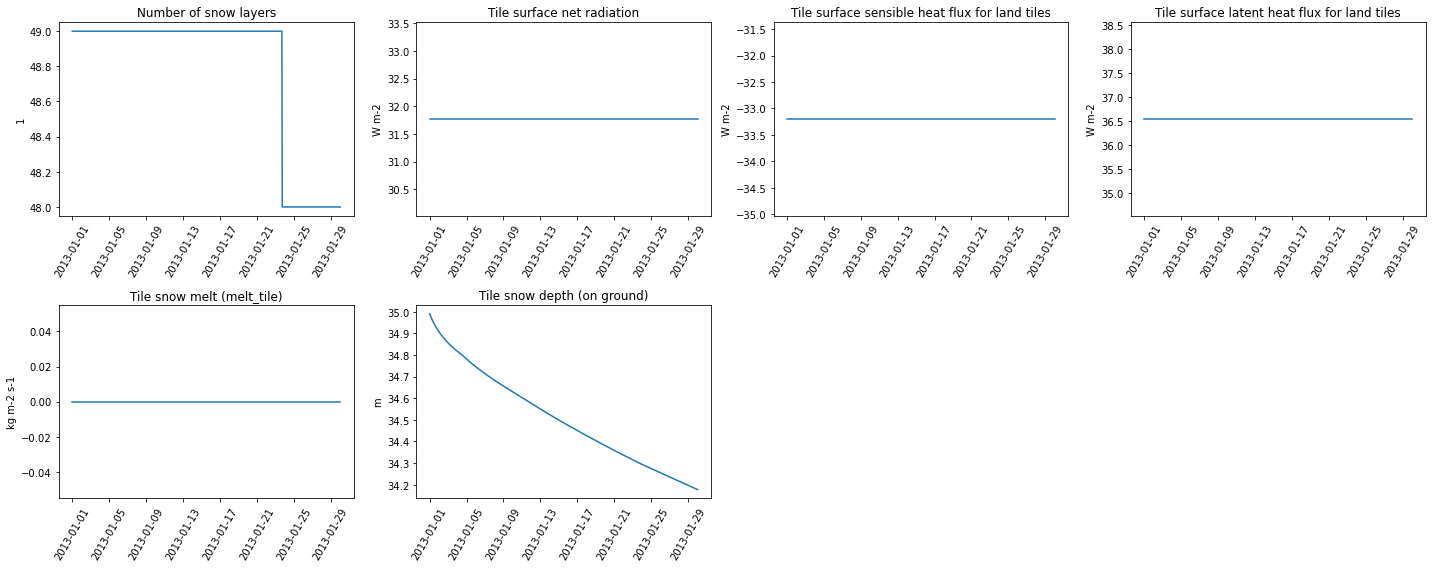

In [26]:
# plot all vars with dimensiosn (time, tile, y, x)

#tile_vars = [v for v in output.variables if output.variables[v].dimensions == ('time', 'tile', 'y', 'x')]

tile_vars = ['nsnow','rad_net_tile','ftl','le','snow_melt', 'snow_depth']

fig, axes = plt.subplots(-(-len(tile_vars) // 4), 4, figsize=(20, 4 * ((len(tile_vars) + 3) // 4)))
axes = axes.flat

for ax, v in zip(axes, tile_vars):
    data = output[v][1:699, 8, 0, 0]
    
    units = getattr(output[v], 'units', '')    
    time = pd.date_range(start=start_time, periods=len(data), freq='H')

    if v == 'tstar':
        data -= 273.15
        units = '$^oC$'
        
    ax.plot(time, data)
    ax.set_title(getattr(output[v], 'long_name', v))
    ax.set_ylabel(units)
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    
    ax.tick_params(axis='x', rotation=60)

for ax in axes[len(tile_vars):]:
    ax.remove()

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Layer thickness array
dzsnow_ml = np.array([0.0100, 0.0112, 0.0125, 0.0140, 0.0157, 
  0.0176, 0.0197, 0.0221, 0.0248, 0.0277, 
  0.0311, 0.0348, 0.0390, 0.0436, 0.0489, 
  0.0548, 0.0613, 0.0687, 0.0769, 0.0862, 
  0.0965, 0.1081, 0.1210, 0.1355, 0.1518, 
  0.1700, 0.1904, 0.2133, 0.2389, 0.2675, 
  0.2996, 0.3356, 0.3758, 0.4209, 0.4715, 
  0.5280, 0.5914, 0.6624, 0.7418, 0.8309, 
  0.9306, 1.0422, 1.1673, 1.3074, 1.4643, 
  1.6400, 1.8368, 2.0572, 2.3031, 2.5795]) 
    

# Compute cumulative depth for plotting (top at zero)
depth = np.cumsum(dzsnow_ml)
midpoints = depth - dzsnow_ml / 2.0

# Create figure
fig, ax = plt.subplots(figsize=(4, 8))

# Plot horizontal lines representing layer boundaries
for z in depth:
    ax.axhline(y=z, color='black', linewidth=0.4)

# Optional: add rectangles or tick labels for layer centers
ax.scatter(np.zeros_like(midpoints), midpoints, s=10, color='blue')

# Reverse y-axis so surface is at top
ax.invert_yaxis()

ax.set_xlabel('Snow layer index (horizontal reference)')
ax.set_ylabel('Depth below surface (m)')
ax.set_title('Prescribed Snow Layer Thicknesses (dzsnow_ml)')
ax.grid(True, linestyle=':')

plt.tight_layout()
plt.show()
